# **CHEM E 545 Midterm Exam** 
Please put team name in the submisson (.ipynb file). Run your notebook so that your outputs are visible and comment throughout your code. **(80 points)**

In this project, you will develop a supervised machine learning model to predict the Gibbs free energy of solvation (ΔG).  ΔG is a crucial property for modeling various chemical processes, including electrochemistry and drug delivery systems.  While traditional methods like quantum mechanics and molecular dynamics have been used extensively for predicting ΔG, machine learning has recently emerged as a popular alternative.  By establishing relationships between molecular structure and activity, machine learning models can effectively predict thermodynamic properties.  Your focus will be on building generalizable machine learning models for ΔG prediction.  Furthermore, you will perform feature selection to identify the most influential molecular descriptors.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

## **Question 1** 
Begin by loading the data and separating it into features (X) and target variable (y).  Handle any missing values by replacing them with zero.  Next, preprocess the data in preparation for machine learning.  Briefly explain the chosen preprocessing method and the rationale behind its selection.  Use a random state of 42 for any processes requiring randomization. **(10 points)**

**Preprocessing Method and Rationale**
1. **Feature Selection:**
* We set X as all features except `gibbs_free_energy` (target) and `Solvent_Type`.
* `Solvent Type` was dropped from X because it was not required for model training. However, it will be used in visualization (Q5) to color-code data points.
2. **Handling Missing Values:**
* As required, we replaced all missing values with zero to ensure consistent feature representation.
3. **Data Splitting:**
* We split the dataset into training (80%), validation(10%), and test(10%) sets.
4. **Scaling (RobustScaler):**
* We applied RobustScaler to scale the dataset, since it is relatively resistant to outliers by scaling based on the median and interquartile range.
* Scaling was applied after splitting to prevent data leakage, ensuring that each dataset (train/validation/test) remains independent and blindfolded, and does not gain insight from the entire dataset.

In [2]:
# Load the dataset
df = pd.read_csv('Gibbs_predictor_545_data_final_2.csv')

In [3]:
# Separate the features and the target variable and keep only numerical features
X = df.drop(columns=['gibbs_free_energy', 'Solvent_Type'])
y = df['gibbs_free_energy']

# Handle missing values by replacing them with zeros
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

## **Question 2**
Based on the problem statement and the nature of the output you are predicting with your machine learning model, justify whether regression or classification is the more appropriate choice. Implement the chosen approach using linear models, Support Vector Machines (SVMs), and Random Forests (RFs). **(20 points)**

Adhere to the following specifications for model development:

**Regression vs. Classification**  
* We chose **regression** over classification because **Gibbs free energy (ΔG) is a continuous variable** rather than discrete categories.

**Choice of Scaler: RobustScaler**
* Our dataset contains extreme outliers. RobustScaler uses the median and interquartile range, making it relatively resistant to extreme values.
* StandardScaler assumes a normal distribution, but since our data contains outliers, it resulted in an unstable model with an MAE standard deviation of 34 billion in Question 3.
* After switching to RobustScaler, the standard deviation of MAE reduced to 17 million, indicating improved stability.
* MinMaxScaler was also considered, but it is highly sensitive to outliers, making it unsuitable for this dataset.
* Final Decision: We use RobustScaler to improve model robustness and ensure models perform better.

### **(a) Data Splitting**
Initially, divide your data into training and testing sets using an 80/20 split. Subsequently, split the testing set into validation and final test sets, each comprising 50% of the original testing data.

In [4]:
# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the test set into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Use the RobustScaler to scale the data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### **(b) Model Parameters**
For the SVM model, utilize the radial basis function (rbf) kernel with a regularization parameter (C) of 10. For the RF model, configure the following hyperparameters: 250 trees, a minimum of 2 samples required to split an internal node, a minimum of 1 sample required to be at a leaf node, the square root of the total number of features as the maximum number of features considered for splitting a node, and disable bootstrapping.

In [5]:
# Define the models individually
linear = LinearRegression()  # Linear regression
svm = SVR(C=10, kernel='rbf')  # Support Vector Regression
rf = RandomForestRegressor(
    n_estimators=250, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features='sqrt', 
    bootstrap=False,
    random_state=42
)  # Random Forest

# Dictionary to map models to their names
model_names = {
    linear: 'Linear Regression', 
    svm: 'Support Vector Regression', 
    rf: 'Random Forest'
}

In [6]:
# Function to fit the model (No prediction yet)
def Q2(model):
    """Fits the model to the training data."""
    model.fit(X_train_scaled, y_train)
    return model

## **Question 3** 
Model Evaluation. Your code should output a .csv file that has the following columns:

```algorithm```

```test_score```

```mean absolute error```

 ```standard deviaiton of mean absolute errors```
(calculated using 10-fold cross on the validation dataset.)


You will have the three performance metrics for each of your three algorithms in your ```output.csv``` file. Also plot these three metrics for your algorithms in one bar plot. **(20 points)**

In [7]:
import csv
import os

def save_results_to_csv(results, filename="output.csv"):
    """Saves the results to a CSV file."""
    
    file_exists = os.path.isfile(filename)
    
    with open(filename, mode='a', newline='') as f:
        writer = csv.writer(f)
        
        # Write header if file does not exist
        if not file_exists:
            writer.writerow(["algorithm", "test_score", "mean absolute error", "standard deviation of mean absolute errors"])
        
        # Write results
        writer.writerow(results)

In [8]:
def Q3(model):
    """Evaluate the model, save results to a CSV file, and print the results."""
    
    # Fit the model
    Q2(model)

    # Calculate test score and mean absolute error
    test_score = model.score(X_test_scaled, y_test)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)

    # Perform 10-fold cross validation
    mae_val = -cross_val_score(model, X_val_scaled, y_val, scoring='neg_mean_absolute_error', cv=10)
    std_mae_val = mae_val.std()

    # Print the results
    print(f'Model: {model_names[model]}')
    print('Test Score:', test_score)
    print('MAE:', mae)
    print('10-Fold Cross-Validation on Validation Set:')
    print('Standard deviation of MAE:', std_mae_val)
    
    # Save the output to a csv file
    save_results_to_csv([model_names[model], test_score, mae, std_mae_val])
    print('Results saved to output.csv')
    print('-' * 50)

In [9]:
Q3(linear)
Q3(svm)
Q3(rf)

Model: Linear Regression
Test Score: 0.820883872980521
MAE: 0.6278660989185791
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 17227202.63896927
Results saved to output.csv
--------------------------------------------------
Model: Support Vector Regression
Test Score: 0.6259129414971231
MAE: 0.8195538406295702
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 0.17827880520614878
Results saved to output.csv
--------------------------------------------------
Model: Random Forest
Test Score: 0.9604334907349524
MAE: 0.21299817232724338
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 0.12855731843717647
Results saved to output.csv
--------------------------------------------------


In [10]:
def Q3_plot():
    """Load the results (test score, MAE, and standard deviation of MAE) from the CSV file and create a logarithmic bar plot."""

    # Load the results from the CSV file
    results = pd.read_csv('output.csv')

    # Create a logarithmic bar plot
    results.plot(x='algorithm', kind='bar', logy=True, figsize=(10, 6))
    plt.ylabel('Value')
    plt.title('Test Score, MAE, and Standard Deviation of MAE of Three Models')
    plt.show()

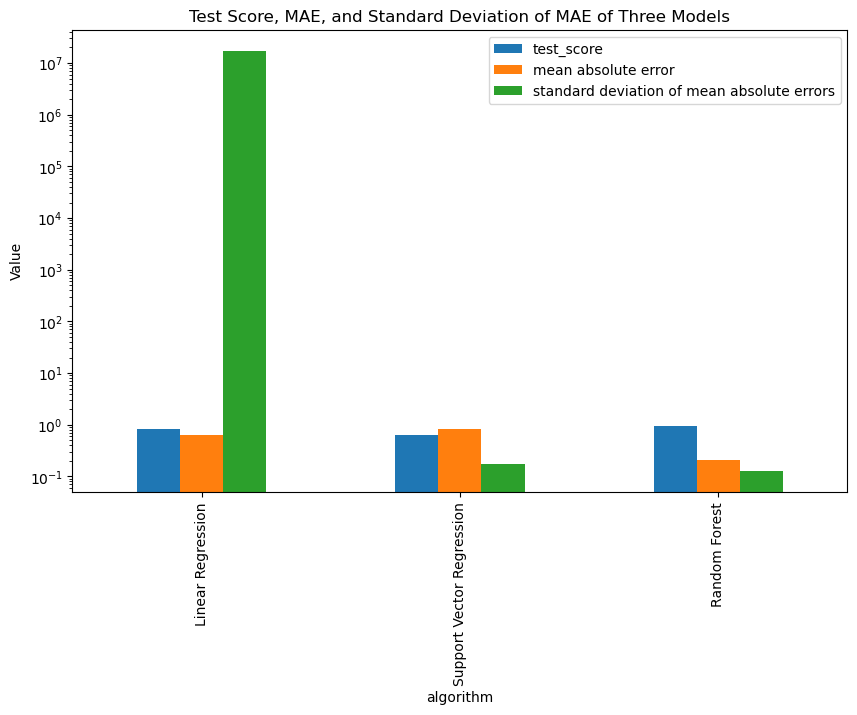

In [11]:
Q3_plot()

## **Question 4** 
Calculate the feature importance for all three models. Note that for non-linear models, simply using coefficients does not provide an accurate estimate of feature importance.  Permutation feature importance is generally recommended in such cases. For consistency, use permutation feature importance for all three models.

### **(1)**
Remove any **negative and zero** importance features and see what happens to MAE and the standard deviation of MAE in the cross_val scores. **(10 points)**

In [12]:
# Dictionary to store the predictions
predictions = {}

In [13]:
def Q4_1(model):
    """Remove features with negative and zero importance and evaluate the model."""
    
    # Fit the model
    Q2(model)

    # Perform permutation importance
    perm_importance = permutation_importance(model, X_val_scaled, y_val, n_repeats=30, random_state=42)

    # Get the mean feature importance
    importances = perm_importance.importances_mean
    indices = np.argsort(importances)[::-1]

    # Keep only indices where importance is greater than 0
    selected_indices = indices[importances[indices] > 0]

    # Filter dataset with selected features
    X_train_perm = X_train_scaled[:, selected_indices]
    X_val_perm = X_val_scaled[:, selected_indices]
    X_test_perm = X_test_scaled[:, selected_indices]

    # Fit the model with the reduced features
    model.fit(X_train_perm, y_train)


    # Predict the test set
    y_pred = model.predict(X_test_perm)
    predictions[model_names[model]] = y_pred  # Store the predictions

    # Perform 10-fold cross validation
    mae_val = -cross_val_score(model, X_val_perm, y_val, scoring='neg_mean_absolute_error', cv=10)
    std_mae_val = mae_val.std()

    # Calculate test score and mean absolute error
    test_score = model.score(X_test_perm, y_test)
    y_pred = model.predict(X_test_perm)
    mae = mean_absolute_error(y_test, y_pred)

    # Print the results
    print(f'Model: {model_names[model]} (Permutation Importance - Positive Features Only)')
    print('Test Score:', test_score)
    print('MAE:', mae)
    print('10-Fold Cross-Validation on Validation Set:')
    print('Standard deviation of MAE:', std_mae_val)
    print('-' * 50)

In [14]:
Q4_1(linear)
Q4_1(svm)
Q4_1(rf)

Model: Linear Regression (Permutation Importance - Positive Features Only)
Test Score: 0.820728075775335
MAE: 0.6278444969307414
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 17306731.135844927
--------------------------------------------------
Model: Support Vector Regression (Permutation Importance - Positive Features Only)
Test Score: 0.6260779505737337
MAE: 0.8302979942303634
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 0.17757776315740914
--------------------------------------------------
Model: Random Forest (Permutation Importance - Positive Features Only)
Test Score: 0.9595443491025023
MAE: 0.21274074070740404
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 0.12991615955381
--------------------------------------------------


### **(2)**
Make a bar plot of the top 10 features. Use only the top features and see what happens to MAE and the standard deviation of MAE in the cross_val scores.**(10 points)**

In [15]:
def Q4_2(model):
    """Keep only top 10 importances, evaluate the model, and plot the feature importances."""
    
    # Fit the model
    model.fit(X_train_scaled, y_train)

    # Perform permutation importance
    perm_importance = permutation_importance(model, X_val_scaled, y_val, n_repeats=30, random_state=42)

    # Get the mean feature importance
    importances = perm_importance.importances_mean
    indices = np.argsort(importances)[::-1]

    # Keep the top 10 features
    X_train_perm = X_train_scaled[:, indices[:10]]
    X_val_perm = X_val_scaled[:, indices[:10]]
    X_test_perm = X_test_scaled[:, indices[:10]]

    # Fit the model with the reduced features
    model.fit(X_train_perm, y_train)

    # Perform 10-fold cross validation
    mae_val = -cross_val_score(model, X_val_perm, y_val, scoring='neg_mean_absolute_error', cv=10)
    std_mae_val = mae_val.std()

    # Calculate test score and mean absolute error
    test_score = model.score(X_test_perm, y_test)
    y_pred = model.predict(X_test_perm)
    mae = mean_absolute_error(y_test, y_pred)

    # Plot a vertical bar chart of the feature importances with X-axis as importance and Y-axis as feature names
    plt.figure(figsize=(10, 6))
    plt.barh(range(10), importances[indices[:10]])
    plt.yticks(range(10), X.columns[indices[:10]])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'{model_names[model]} (Permutation Importance)')
    plt.gca().invert_yaxis()
    plt.show()


    # Print the results
    print(f'Model: {model_names[model]} (Permutation Importance - Top 10 Features)')
    print('Test Score:', test_score)
    print('MAE:', mae)
    print('10-Fold Cross-Validation on Validation Set:')
    print('Standard deviation of MAE:', std_mae_val)
    print('-' * 50)

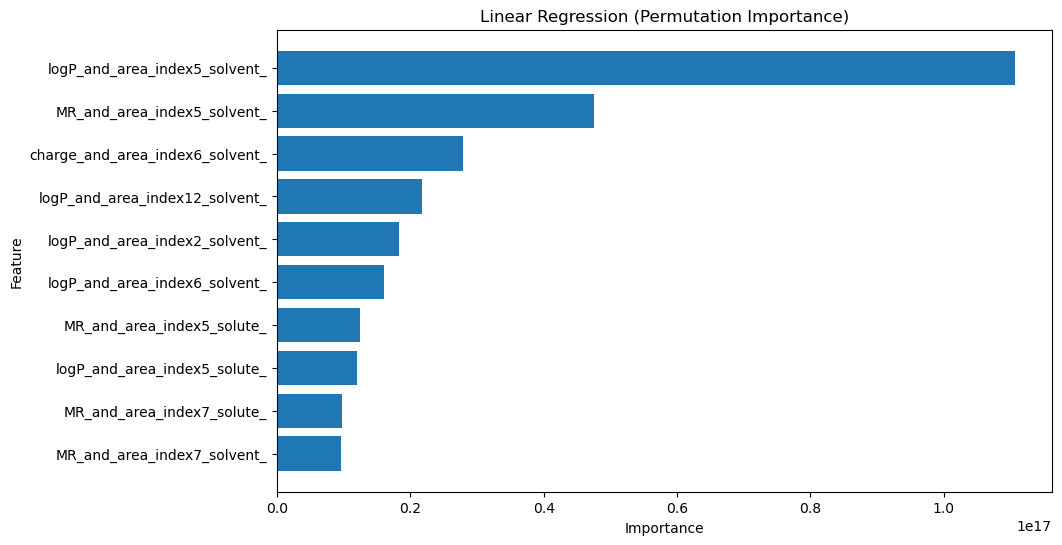

Model: Linear Regression (Permutation Importance - Top 10 Features)
Test Score: 0.14586859188225
MAE: 1.4282778203010194
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 0.2181926085208969
--------------------------------------------------


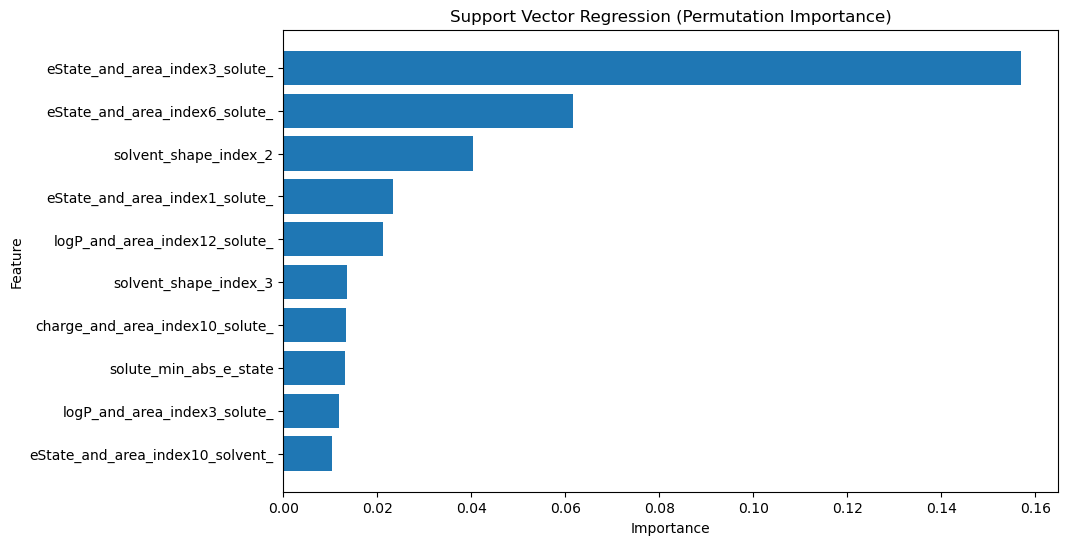

Model: Support Vector Regression (Permutation Importance - Top 10 Features)
Test Score: 0.46049017611213194
MAE: 1.1072752037180158
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 0.21639626384807412
--------------------------------------------------


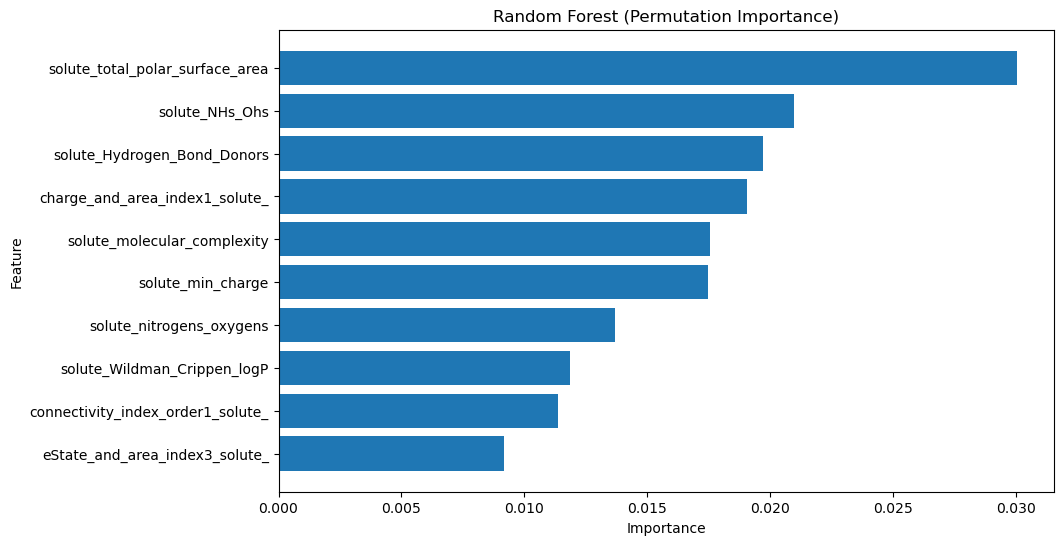

Model: Random Forest (Permutation Importance - Top 10 Features)
Test Score: 0.7012483417343955
MAE: 0.7318485290886253
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 0.21032003852005662
--------------------------------------------------


In [16]:
Q4_2(linear)
Q4_2(svm)
Q4_2(rf)

## **Question 5**
Visualize the performance of your model in 4.1 on the entire dataset by plotting the predicted ΔG on the y-axis and the experimental ΔG on the x-axis. Color the data points based on the solvent group type. **(5 points)**

In [17]:
def Q5(model):
    """Plots predicted Gibbs free energy vs actual values with color coding for solvent type."""
    
    # Get the predicted values
    y_pred = predictions[model_names[model]]

    # Get solvent types and assign unique colors
    solvent_types = df.loc[y_test.index, "Solvent_Type"]
    unique_solvents = solvent_types.unique()
    color_map = {solvent: i for i, solvent in enumerate(unique_solvents)}

    # Convert solvent types to numerical color labels
    colors = solvent_types.map(color_map)

    # Create scatter plot
    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(y_test, y_pred, c=colors, cmap='viridis', alpha=0.7)

    # Plot y = x line for reference
    plt.plot(y_test, y_test, color='red', linestyle='--')

    # Labels and title
    plt.xlabel("Experimental ΔG")
    plt.ylabel("Predicted ΔG")
    plt.title(f"Predicted vs. Actual Gibbs Free Energy ({model_names[model]})")

    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / len(unique_solvents)), markersize=8)
               for i, solvent in enumerate(unique_solvents)]
    plt.legend(handles, unique_solvents, title="Solvent Type", loc="upper left", bbox_to_anchor=(1, 1))

    plt.show()

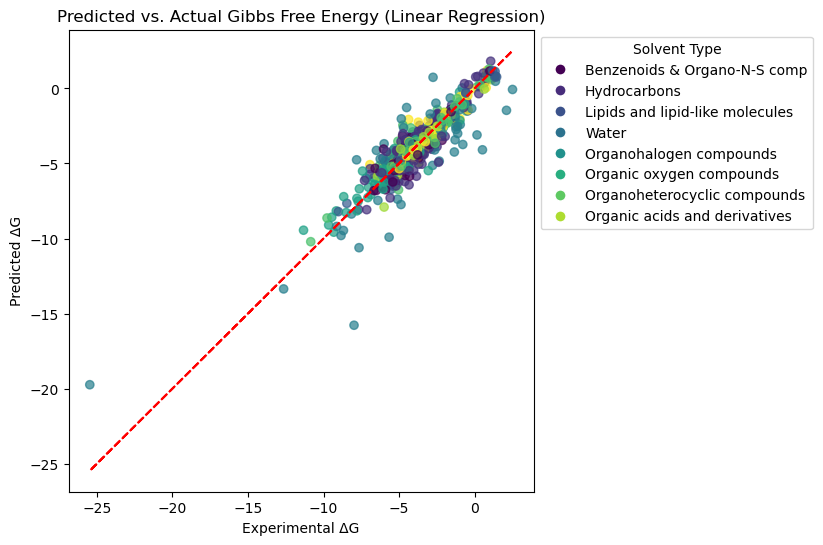

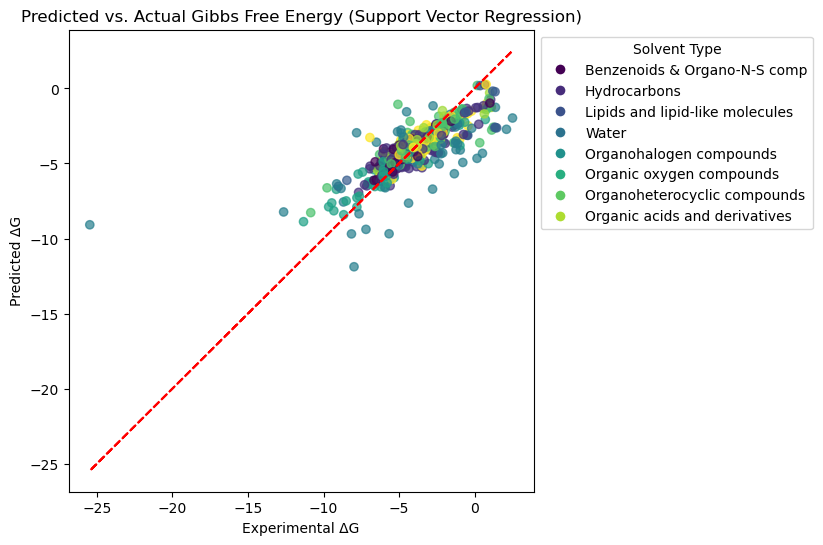

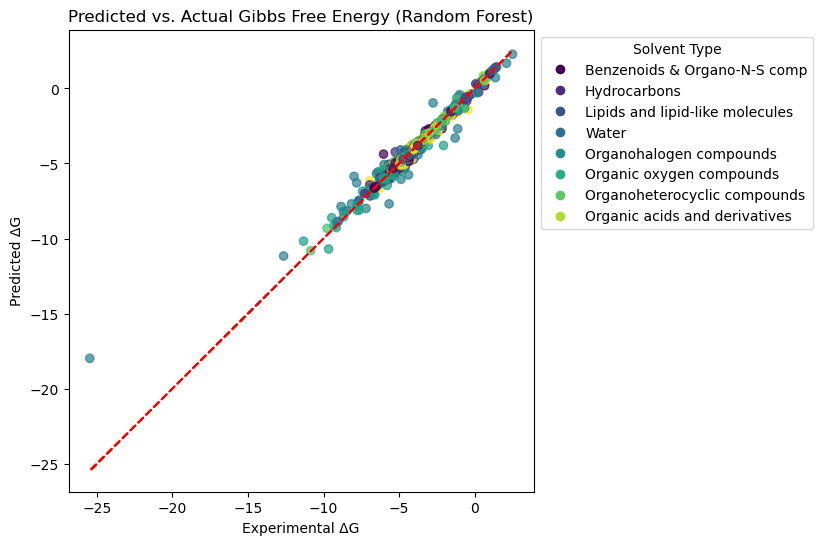

In [18]:
Q5(linear)
Q5(svm)
Q5(rf)

## **Question 6**
Summarize your work and discuss what you learnt. **(5 points)**

**Summary of Work**  
In this project, we developed a supervised machine learning method to predict Gibbs free energy of solvation (ΔG) using regression techniques. The workflow included:
1. **Choosing Regression over Classification**
* ΔG is a continuous variable.
2. **Data Preprocessing**
* Feature Slection
* Handle Missing Values
* Data Splitting
* Scaling
3. **Model Selection & Evaluation**
* Implemented Linear Regression, Support Vector Machine (SVM), and Random Forest Regression.
* Measured test score, mean absolute error (MAE), and standard deviation of MAE using 10-fold cross validation.
* Stored results in `output.csv`.
4. **Feature Importance Analysis**
* Applied permutation importance to identify influential features.
* Evaluated model performance after removing zero and negative features, and selecting the top 10 features.
* Visualized the top 10 features using bar plots.
5. **Model Performance Visualization**
* Created a Predicted vs. Actual ΔG scatter plot, color-coded by solvent type, to assess model accuracy.

**Learnings from the Project**
* Proper feature selection, handling missing values, and choosing different scaler impact model stability.
* SVM and Random Forest outperformed Linear Regression, highlighting the importance of choosing the right models suitable for non-linear relationships.
* Using permutation importance helped identify key importances.
* Problem Solving and Debugging. Encountering issues and bugs require critical thinking and testing different approaches.
* The project provided practical experience in using ML for Chemical Engineering applications, showing how models can help predict thermodynamic properties like Gibbs free energy.

**Further Improvements & Observations**
* **High Standard Deviation in Cross-Validation**  
The extreme variance in MAE for the Linear Regression model suggests potential issues in preprocessing.
* **Possible Improvements:**  
    - Instead of assuming all data points are valid, we could identify any extreme values to improve stability.
    - Replacing all missing values with zero might not be ideal. Using column mean or median might lead to better generalization.
    - Instead of Mean Absolute Error, we could try Median Absolute Error, which is less sensitive to outliers and can give a general representation to the model performance.